In [1]:
%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as NC
import numpy as np

import arrow
import datetime
import pandas as pd
from dateutil import tz
from salishsea_tools import tidetools
from salishsea_tools import stormtools_revisions
from salishsea_tools import (nc_tools,viz_tools)
import csv

from __future__ import division

In [2]:
path = '/ocean/nsoontie/MEOPAR/SalishSea/results/storm-surges/revisions/nov2009/'

msl=stormtools_revisions.MSLS

runs = {'all_forcing','tidesonly'}

fUs={}; fVs={}; fTs={};

for key in runs:
    fUs[key] = NC.Dataset(path + key +'/SalishSea_4h_20091116_20091122_grid_U.nc','r');
    fVs[key] = NC.Dataset(path + key +'/SalishSea_4h_20091116_20091122_grid_V.nc','r');
    fTs[key] = NC.Dataset(path + key +'/SalishSea_4h_20091116_20091122_grid_T.nc','r');

In [3]:


fB = NC.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc','r')
lats = fB.variables['nav_lat']
lons = fB.variables['nav_lon']
D = fB.variables['Bathymetry']



In [4]:


stations = {'PointAtkinson': 7795, 'Victoria': 7120, 'PatriciaBay': 7277, 'CampbellRiver': 8074}
#datums = {'PointAtkinson': 3.09, 'Victoria': 1.881, 'PatriciaBay': 2.256, 'CampbellRiver': 2.916, 
 #         'CrescentBeach': 2.44, 'WhiteRock': 2.85, 'BoundaryBay': 1 }
thalwegs = ['Thalweg1','Thalweg2', 'Thalweg3', 'Thalweg4', 'Thalweg5', 'Thalweg6']
allstations = {'PointAtkinson': 7795, 'Victoria': 7120, 'PatriciaBay': 7277, 'CampbellRiver': 8074,
               'CrescentBeach': 2.44, 'WhiteRock': 2.85 , 'BoundaryBay': 1,
               'Thalweg1': [], 'Thalweg2': [], 'Thalweg3': [], 'Thalweg4': [], 'Thalweg5': [], 'Thalweg6': [],
               'Plume': 1} 
#datums from t_xtide
run_stations={}
us={}; vs={}; lats={}; lons={}; tmps={}; sals={}; sshs={}; ts={};

for run in runs:
    for key in allstations:
        string = path + run + '/1h_' + key + '.nc'
        run_stations[key] = NC.Dataset(string,'r');
        tim = run_stations[key].variables['time_counter']
        t_count=np.arange(0, tim.shape[0])
        t=nc_tools.timestamp(run_stations[key],t_count)
        tlist=[]
        for a in t:
           tlist.append(a.datetime) 
        ts[run]=tlist
    [us[run], vs[run], lats[run], lons[run], tmps[run], sals[run], sshs[run]] = stormtools_revisions.combine_data(run_stations)
    run_stations={};


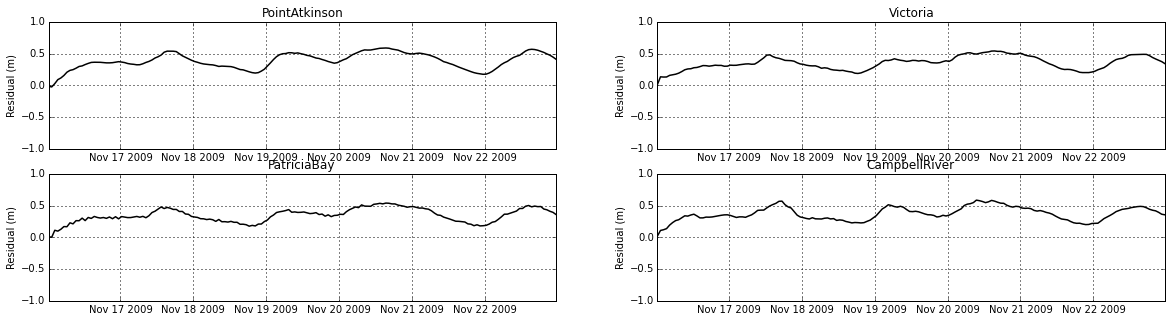

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(20, 5))
sts = ['PointAtkinson','Victoria','PatriciaBay', 'CampbellRiver']
for (ax,location) in zip(axs.flat, sts):
    anom_model=sshs['all_forcing'][location][:,0,0]-sshs['tidesonly'][location][:,0,0]
    ax.plot(ts['all_forcing'], anom_model, 'k-',label='Model',lw=1.5)
    ax.set_ylim([-1,1])
    ax.grid(True,lw=1)
    ax.set_ylabel('Residual (m)')
    ax.set_title(location)

Observations and tidal predictions

In [6]:


start='31-Dec-2008'; end='02-Jan-2010'
wlev_meas={}; ttide={}; 


for key in stations:
    location=key
    #filename for predictions
    filename='/data/nsoontie/MEOPAR/storm-surge/Revisions/tides/analysis/'+location+'_t_tide_compare8_' +start+'_'+end+'_snr2_filter.csv'
    [ttide[key], _] = stormtools_revisions.load_tidal_predictions(filename)
    
    #filename for obs
    filename = '/data/nsoontie/MEOPAR/storm-surge/Revisions/tides/analysis/wlev_'+str(stations[key])+'_'+start+'_'+end+'.csv'
    wlev_meas[key] = stormtools_revisions.load_observations(filename)


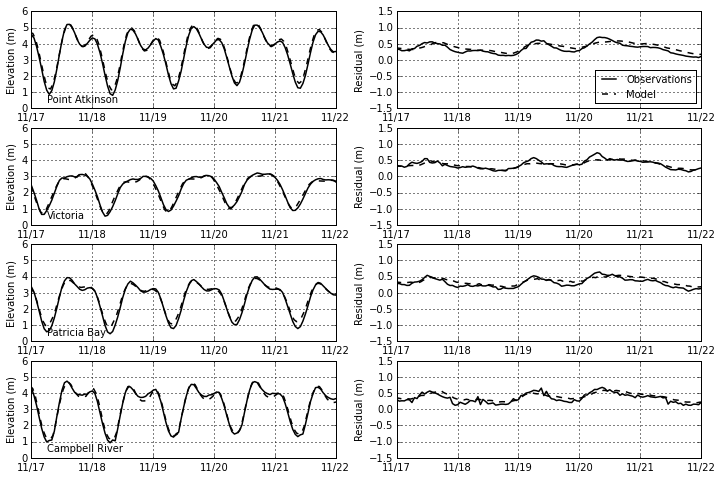

In [7]:
fig, axs = plt.subplots(4, 2, figsize=(20, 10))
import matplotlib.dates as mdates
from datetime import timedelta

font = {'size'   : 10}

pylab.rc('font', **font)

s='16-Nov-2009'; e='23-Nov-2009';
unaware=datetime.datetime.strptime(s,"%d-%b-%Y")
sdt = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(e,"%d-%b-%Y")
edt = unaware.replace(tzinfo=tz.tzutc())

#axis limits
s = '17-Nov-2009'; e='22-Nov-2009';
unaware=datetime.datetime.strptime(s,"%d-%b-%Y")
sax = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(e,"%d-%b-%Y")
eax = unaware.replace(tzinfo=tz.tzutc())

sts = ['PointAtkinson','Victoria','PatriciaBay', 'CampbellRiver']
proper = ['Point Atkinson','Victoria','Patricia Bay', 'Campbell River']
bg={}
for (ax,location,name) in zip(axs[:,0], sts,proper):
    hfmt = mdates.DateFormatter('%m/%d')
    ssh_corr=stormtools_revisions.correct_model(sshs['all_forcing'][location][:,0,0],ttide[location],sdt,edt)
    ax.plot(wlev_meas[location].time, wlev_meas[location].slev, 'k', label='Observations',lw=1.5)
    ax.plot(ts['all_forcing'], ssh_corr+msl[location], 'k--',label='Corrected model',lw=1.5)
    ax.text(sax+timedelta(hours=6),0.4,name,fontsize=10)
    ax.set_xlim([sax,eax])
    ax.set_ylim([0,6])
    ax.set_ylabel('Elevation (m)')
    ax.grid(True,lw=1)
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(hfmt)


for (ax,location) in zip(axs[:,1], sts):
    hfmt = mdates.DateFormatter('%m/%d')
    anom_obs=stormtools_revisions.observed_anomaly(ttide[location],wlev_meas[location],msl[location])
    anom_model=sshs['all_forcing'][location][:,0,0]-sshs['tidesonly'][location][:,0,0]
    
    ax.plot(wlev_meas[location].time, anom_obs, 'k', label='Observations',lw=1.5)
    ax.plot(ts['all_forcing'], anom_model, 'k--',label='Model',lw=1.5)
    ax.set_xlim([sax,eax])
    ax.set_ylim([-1.5,1.5])
    ax.grid(True,lw=1)
    ax.set_ylabel('Residual (m)')
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(hfmt)

axs[0,1].legend(loc=4,prop={'size':10})
    
fig.set_size_inches(12,8)

Output surge amplitudes etc

In [8]:
sts = ['PointAtkinson','Victoria','PatriciaBay', 'CampbellRiver']
#sim limits
s='16-Nov-2009'; e='23-Nov-2009';
unaware=datetime.datetime.strptime(s,"%d-%b-%Y")
ssim = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(e,"%d-%b-%Y")
esim = unaware.replace(tzinfo=tz.tzutc())

#analysys limits
s = '18-Nov-2009'; e='22-Nov-2009';
unaware=datetime.datetime.strptime(s,"%d-%b-%Y")
san = unaware.replace(tzinfo=tz.tzutc())
unaware=datetime.datetime.strptime(e,"%d-%b-%Y")
ean = unaware.replace(tzinfo=tz.tzutc())


outfile = 'statisitics_nov2009_revisions.csv'
flag1 = 'Water level statistics'
flag2 = 'Surge statistics'

with open(outfile, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    #water level statistics
    writer.writerow([flag1])
    writer.writerow([
                    'Location', 
                    'obs max', 'model max','max timing (obs)', 'max timing (model)',
                    'mean error', 'mean abs error', 'rms error', 'gamma2', 'correlation',
                    'willmott score', 'mean obs', 'mean model', 'std obs', 'std model'
                    ])
    for stn in sts:
        ssh_corr=stormtools_revisions.correct_model(sshs['all_forcing'][stn][:,0,0],ttide[stn],ssim,esim)
        [max_obs,max_model,tmax_obs,tmax_model,
        mean_error,mean_abs_error,rms_error,
        gamma2, corr, ws, mean_obs, mean_model,
        std_obs, std_model] = stormtools_revisions.get_statistics(wlev_meas[stn].slev,np.array(ssh_corr +msl[stn]),
                                             wlev_meas[stn].time,np.array(ts['all_forcing']),san,ean)
        
        writer.writerow([stn,
                        max_obs,max_model,tmax_obs,tmax_model,
                        mean_error,mean_abs_error,rms_error,
                        gamma2, corr[0,1],ws,mean_obs, mean_model, std_obs,std_model] )

    #write analysis period
    writer.writerow(['Analysis period',
                    san,ean])
    writer.writerow([' '])
   
    #surge statisitcs
    writer.writerow([flag2])
    writer.writerow([
                    'Location', 
                    'obs max', 'model max','max timing (obs)', 'max timing (model)',
                    'mean error', 'mean abs error', 'rms error', 'gamma2', 'correlation',
                    'willmott score', 'mean obs', 'mean model', 'std obs', 'std model'
                    ])
    for stn in sts:
        anom_obs=stormtools_revisions.observed_anomaly(ttide[stn],wlev_meas[stn],msl[stn])
        anom_model=sshs['all_forcing'][stn][:,0,0]-sshs['tidesonly'][stn][:,0,0]
        [max_obs,max_model,tmax_obs,tmax_model,
        mean_error,mean_abs_error,rms_error,
        gamma2, corr, ws, mean_obs, mean_model,
        std_obs, std_model] = stormtools_revisions.get_statistics(anom_obs,np.array(anom_model),
                                             wlev_meas[stn].time,np.array(ts['all_forcing']),san,ean)
        
        writer.writerow([stn,
                        max_obs,max_model,tmax_obs,tmax_model,
                        mean_error,mean_abs_error,rms_error,
                        gamma2, corr[0,1],ws,mean_obs, mean_model, std_obs,std_model] )

    #write analysis period
    writer.writerow(['Analysis period',
                    san,ean])

Look at wind field. Model may not be most accurate though.